# Data Preparation

In this notebook, the data of the main and pilot study are integrated and saved as a h5ad file.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import warnings
import scanpy as sc

import data_support as sup
import scp.utils as utils
import scp.benchmark_models as bm
import scp.metrics as metrics

warnings.filterwarnings("ignore")

np.random.seed(0)

## 1. Data loading

Let's load the data.

In [2]:
MAIN_DIR = "../../data/raw/manns_inhouse/MAIN/"
PILOT_DIR = "../../data/raw/manns_inhouse/PILOT/"

In [3]:
main_adata = sup.load_main_data(MAIN_DIR)
main_adata = sup.preprocess(main_adata)

preprocess input: (4566, 2703)
sc.pp.filter_genes: (4566, 2703)
sc.pp.filter_cells: (4566, 2703)
filter: (4566, 2018)


In [4]:
pilot_adata = sup.load_pilot_data(PILOT_DIR)
pilot_adata = sup.preprocess(pilot_adata)

preprocess input: (454, 3306)
sc.pp.filter_genes: (454, 3305)
sc.pp.filter_cells: (454, 3305)
filter: (454, 2963)


In [5]:
pilot_adata = utils.reshape_anndata_like(adata=pilot_adata, adata_like=main_adata)

transferring 447 cells and 1783 proteins during reshape.


Let's do batch correction.

In [6]:
main_adata.layers["raw"] = main_adata.X.copy()

sup.correct_batch(main_adata)
main_adata.layers["batch_corrected"] = main_adata.X.copy()

In [7]:
pilot_adata.layers["raw"] = pilot_adata.X.copy()

sup.correct_batch(pilot_adata)
pilot_adata.layers["batch_corrected"] = pilot_adata.X.copy()

In [8]:
print(f"pilot intensity coverage: {metrics.get_coverage(pilot_adata[~np.isnan(pilot_adata.X).all(axis=1)].X):.2%}")

pilot intensity coverage: 76.32%


Let's comebine the two datasets.

In [9]:
x_combined = utils.fill_if_nan(main_adata.X, pilot_adata.X)

In [10]:
print(f"pilot intensity coverage:    {metrics.get_coverage(pilot_adata.X):.2%}")
print(f"main intensity coverage:     {metrics.get_coverage(main_adata.X):.2%}")
print(f"combined intensity coverage: {metrics.get_coverage(x_combined):.2%}")

pilot intensity coverage:    7.47%
main intensity coverage:     69.66%
combined intensity coverage: 71.28%


Let's integrate the data.

In [11]:
pilot_adata.layers["corrected"], main_adata.layers["corrected"] = sup.integrate_dataset(pilot_adata.layers["batch_corrected"], main_adata.layers["batch_corrected"])

## 2. Data integration plots

### Overview

The dataset integration is based on overlapping intensities between the two datasets:

In [12]:
overlap_mask = np.logical_and(~np.isnan(pilot_adata.layers["raw"]), ~np.isnan(main_adata.layers["raw"]))

print(f"Overlapping intensities: {np.sum(overlap_mask)}")
print(f"Patients in pilot and main: {np.sum(np.any(overlap_mask, axis=1))}")
print(f"Proteins in pilot and main: {np.sum(np.any(overlap_mask, axis=0))}")

Overlapping intensities: 539467
Patients in pilot and main: 447
Proteins in pilot and main: 1783


Text(0.5, 1.0, 'Intensities per protein in both main and pilot')

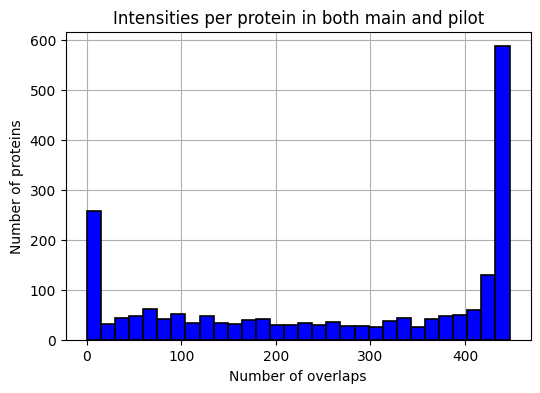

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(np.sum(overlap_mask, axis=0), bins=30, color="blue", edgecolor="black", linewidth=1.2)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_xlabel("Number of overlaps")
ax.set_ylabel("Number of proteins")
ax.set_title("Intensities per protein in both main and pilot")

Let's look at the effect of the corrections.

In [16]:
def plot_pilot_main(pilot, main, title, ax):
    pearson = pearsonr(pilot, main)
    ax.text(0.04, 0.84, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    mse = np.mean((pilot - main) ** 2)
    ax.text(0.04, 0.72, f"MSE:{mse:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"), transform=ax.transAxes)

    ax.scatter(pilot, main, s=.5, alpha=0.3)
    x_step = np.linspace(*ax.get_xlim())
    ax.plot(x_step, x_step, color="black", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("log intensity in pilot")
    ax.set_ylabel("log intensity in main")
    ax.grid(True)
    ax.set_axisbelow(True)

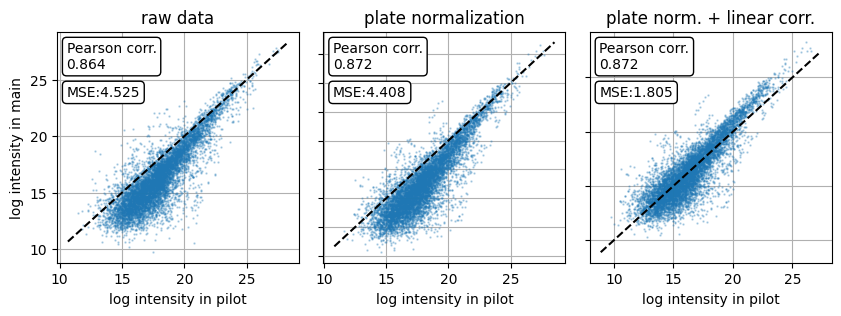

In [18]:
overlap_mask = ~np.isnan(pilot_adata.X) & ~np.isnan(main_adata.X)
row_idx, col_idx = np.where(overlap_mask)

n = 8_000
idx = np.random.choice(len(row_idx), n, replace=False)

fig, axes = plt.subplots(figsize=(10, 3), ncols=3)
plt.subplots_adjust(wspace=0.1)

pilot_sub = pilot_adata.layers["raw"][row_idx[idx], col_idx[idx]]
main_sub = main_adata.layers["raw"][row_idx[idx], col_idx[idx]]
plot_pilot_main(pilot_sub, main_sub, "raw data", axes[0])

pilot_sub = pilot_adata.layers["batch_corrected"][row_idx[idx], col_idx[idx]]
main_sub = main_adata.layers["batch_corrected"][row_idx[idx], col_idx[idx]]
plot_pilot_main(pilot_sub, main_sub, "plate normalization", axes[1])
axes[1].set_yticklabels([])
axes[1].set_ylabel("")

pilot_sub = pilot_adata.layers["corrected"][row_idx[idx], col_idx[idx]]
main_sub = main_adata.layers["corrected"][row_idx[idx], col_idx[idx]]
plot_pilot_main(pilot_sub, main_sub, "plate norm. + linear corr.", axes[2])
axes[2].set_yticklabels([])
axes[2].set_ylabel("")

plt.savefig("study_intergration", dpi=200, bbox_inches="tight")

### Histogram of correlations between overlapping intensities


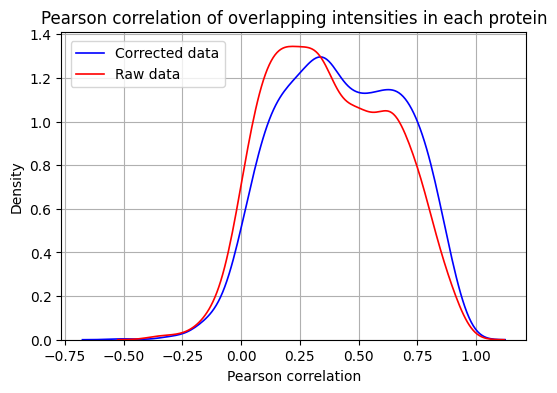

In [16]:
raw_corrs = metrics.compare_intensities_protein_wise(main_adata.layers["raw"], pilot_adata.layers["raw"])
corrected_corrs = metrics.compare_intensities_protein_wise(main_adata.layers["corrected"], pilot_adata.layers["corrected"])

fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(corrected_corrs["pearson"], ax=ax, color="blue", linewidth=1.2, label="Corrected data")
sns.kdeplot(raw_corrs["pearson"], ax=ax, color="red", linewidth=1.2, label="Raw data")
ax.set_title("Pearson correlation of overlapping intensities in each protein")
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("Density")
ax.legend(loc=(0.02, 0.82))
ax.grid(True)
ax.set_axisbelow(True)

### PCA

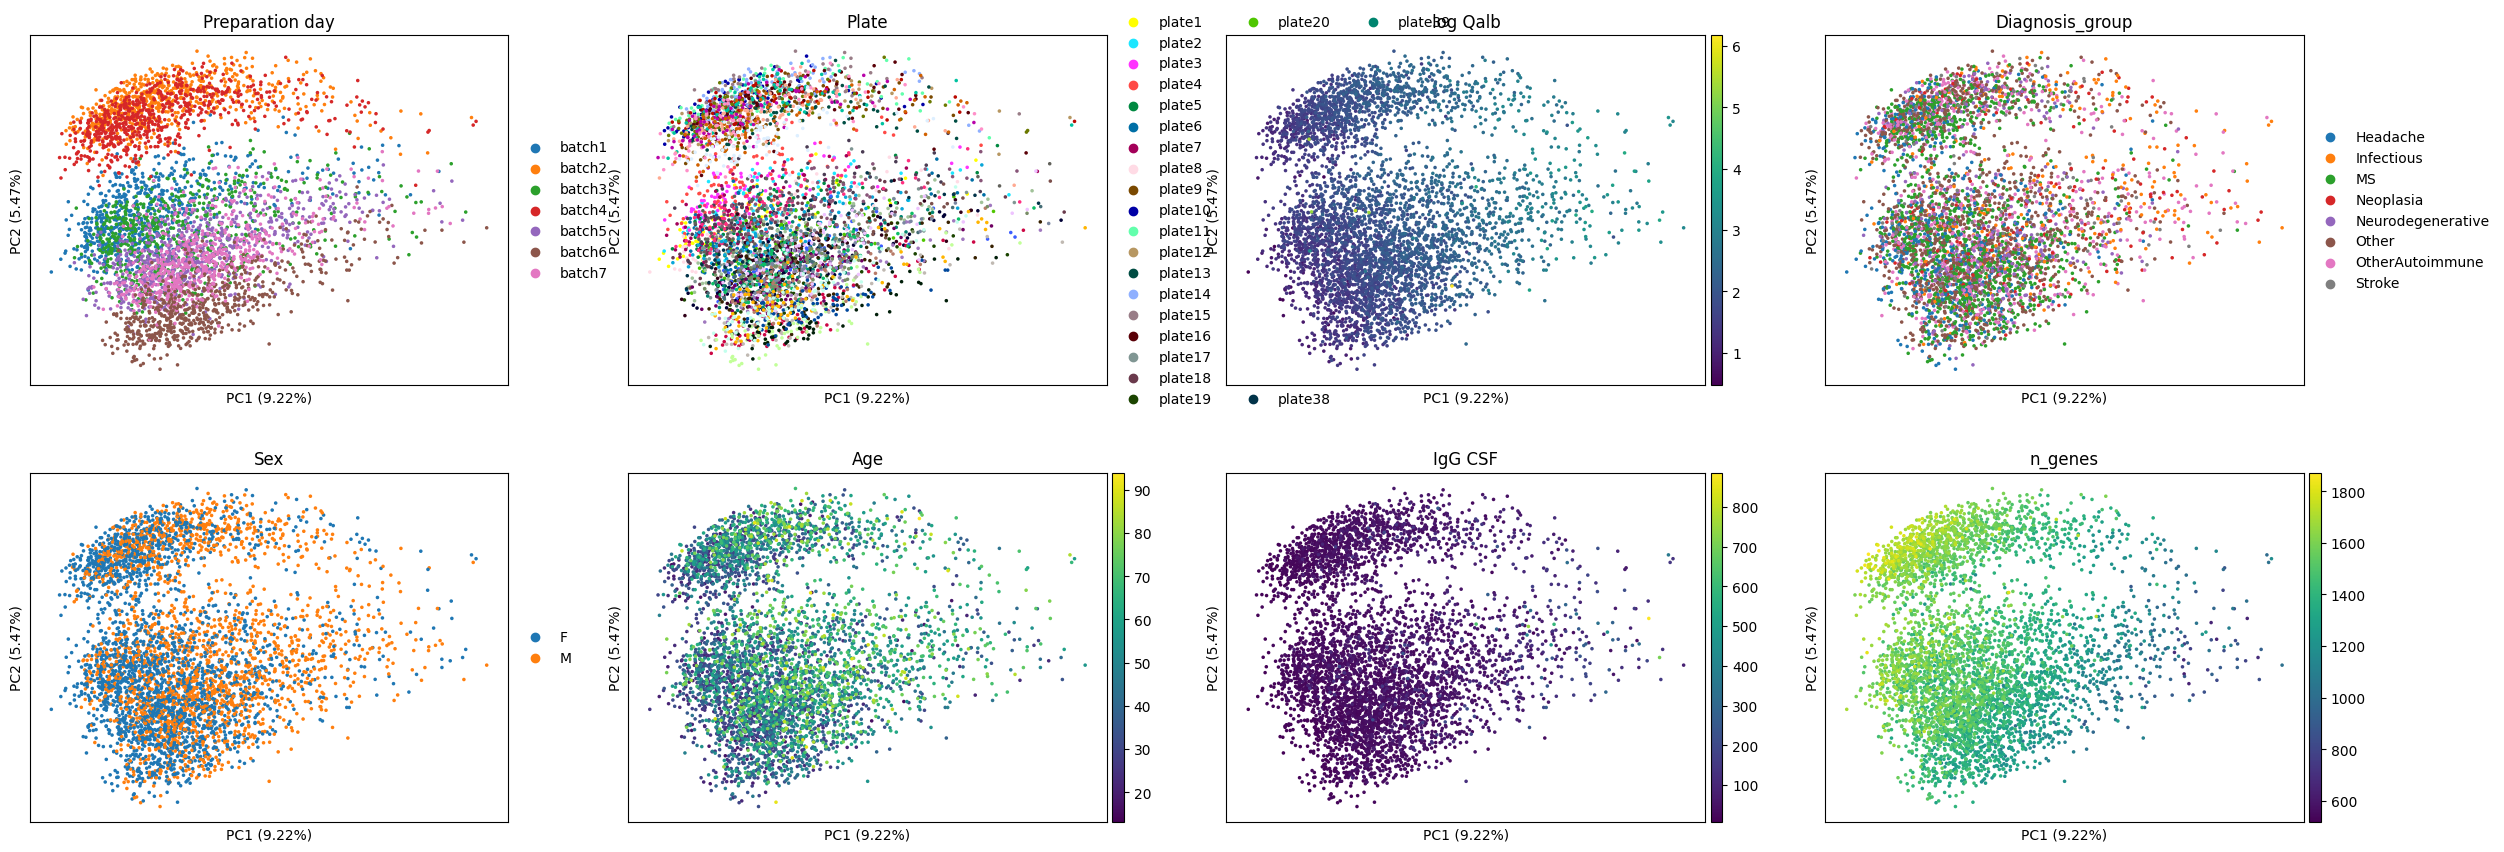

In [17]:
main_adata.X = bm.impute_downshifted_normal_sample(main_adata, layer="raw")

sc.tl.pca(main_adata)

sc.pl.pca(
    main_adata,
    annotate_var_explained=True,
    color=["Preparation day", "Plate", "log Qalb", "Diagnosis_group", "Sex", "Age", "IgG CSF", "n_genes"], 
    components=["1,2"],
)

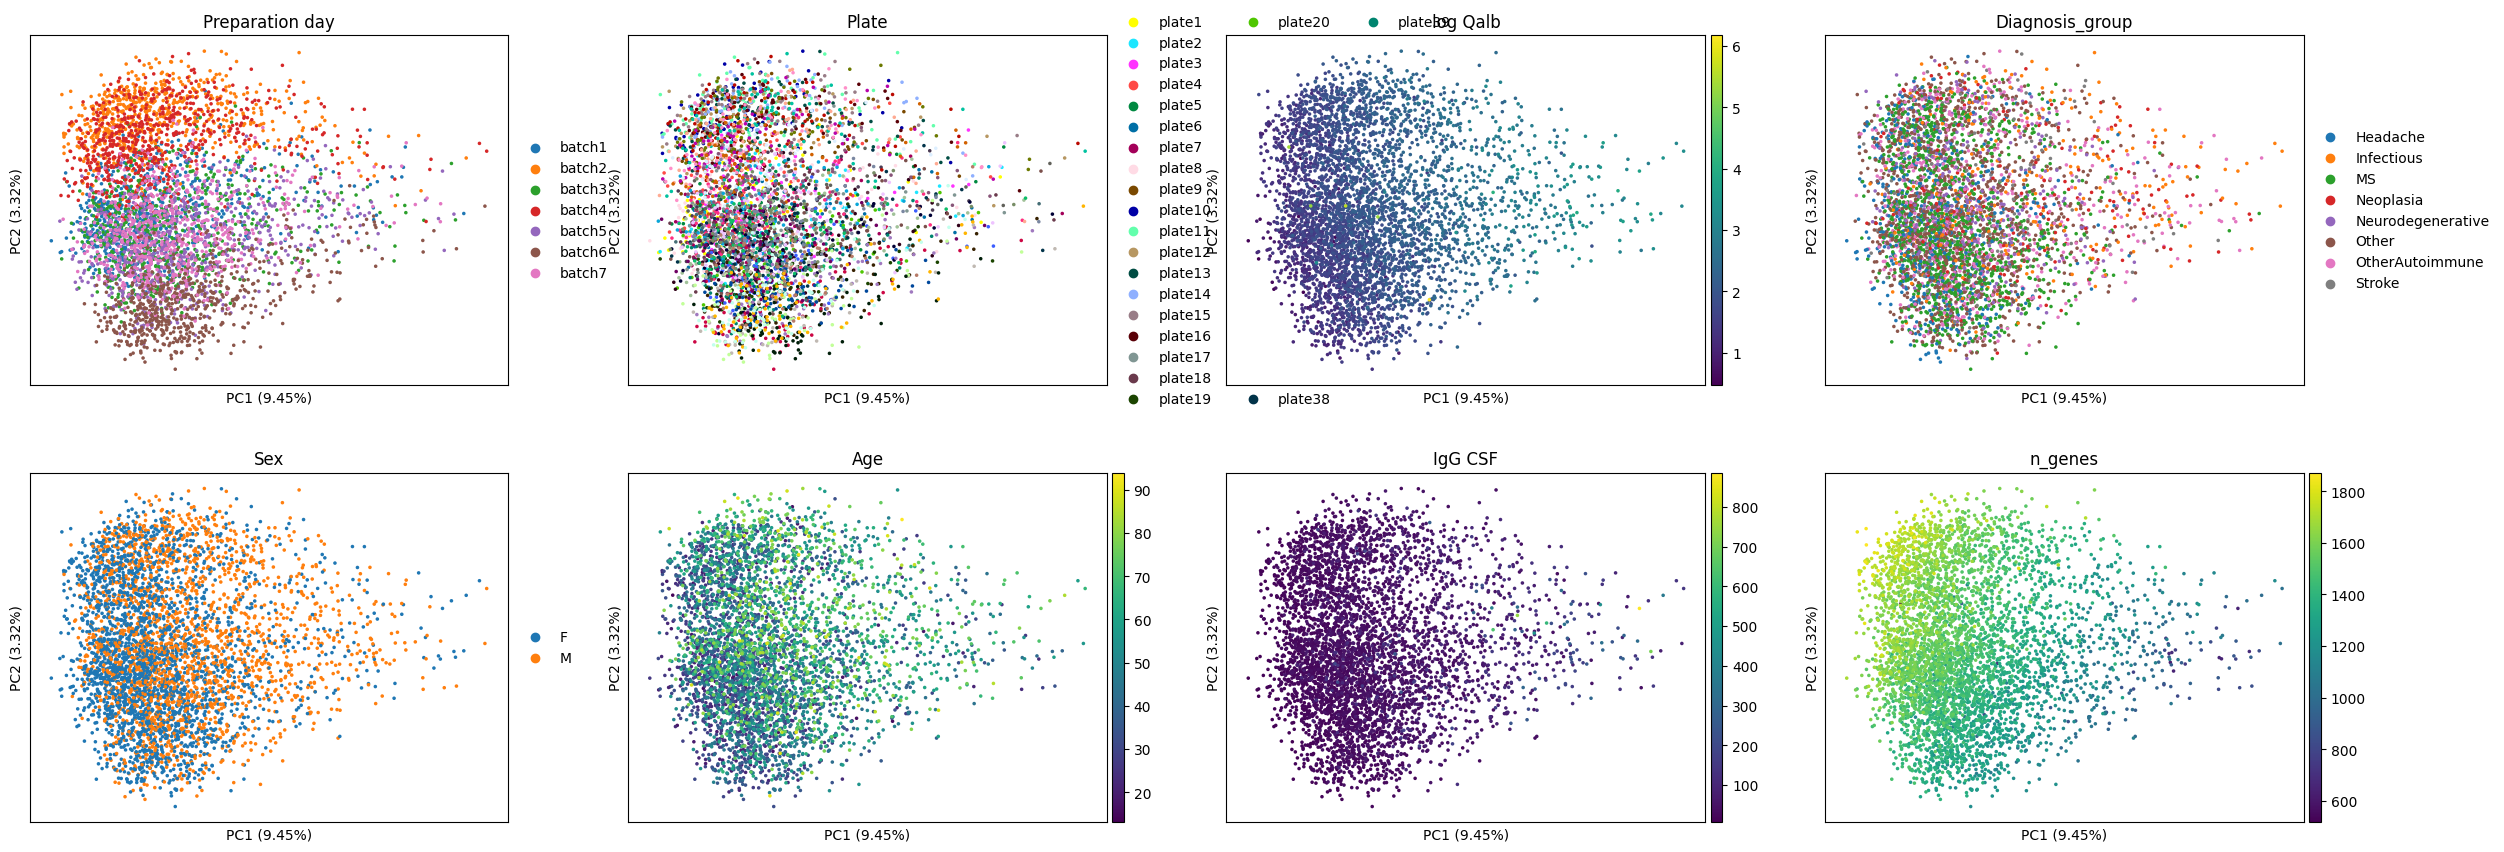

In [18]:
main_adata.X = bm.impute_downshifted_normal_sample(main_adata, layer="corrected")

sc.tl.pca(main_adata)

sc.pl.pca(
    main_adata,
    annotate_var_explained=True,
    color=["Preparation day", "Plate", "log Qalb", "Diagnosis_group", "Sex", "Age", "IgG CSF", "n_genes"], 
    components=["1,2"],
)

## 3. Data saving

In [19]:
adata = sup.load_data(MAIN_DIR, PILOT_DIR, do_batch_correction=True, integrate=True)

preprocess input: (4566, 2703)
sc.pp.filter_genes: (4566, 2703)
sc.pp.filter_cells: (4566, 2703)
filter: (4566, 2018)
preprocess input: (454, 3306)
sc.pp.filter_genes: (454, 3305)
sc.pp.filter_cells: (454, 3305)
filter: (454, 2963)
transferring 447 cells and 1783 proteins during reshape.

main intensity coverage:     69.66%
pilot intensity coverage:    7.47%
combined intensity coverage: 71.28%


In [20]:
adata.write("../../data/processed/manns_inhouse.h5ad")